# Модель для предсказания риска сердечного приступа

В рамках текущего проекта необходимо разработать модель машинного обучения, которая поможет врачам предсказывать риск сердечного приступа и назначать таким пациентам дополнительные обследования.

Нужно создать модель, которая будет предсказывать риск сердечного приступа и выдавать ответ в виде бинарного результата (1 - высокий риск сердечного приступа, 0 - низкий риск).

План исследования:

- проверить наличие пропусков и дубликатов;
- изменить типы данных там, где это необходимо;
- проверить данные на дисбаланс классов, если нужно - исправить;
- провести исследовательский анализ данных;
- провести корреляционный анализ признаков;
- найти и удалить признаки с косвенной утечкой целевого признака;
- решить задачу классификации.

Медицинские показатели и их описание

Age (Возраст) — количество полных лет пациента.

Cholesterol (Холестерин) — уровень липопротеинов в крови, важный показатель липидного обмена.

Heart rate (Пульс) — частота сердечных сокращений в покое.

Diabetes (Диабет) — наличие или отсутствие сахарного диабета.

Family History (Семейный анамнез) — информация о заболеваниях ближайших родственников.

Smoking (Курение) — статус курения (курит/не курит).

Obesity (Ожирение) — наличие избыточной массы тела.

Alcohol Consumption (Употребление алкоголя) — частота и количество употребляемого алкоголя.

Exercise Hours Per Week (Часы физической активности в неделю) — время, затраченное на физические упражнения.

Diet (Питание) — характер и режим питания пациента.

Previous Heart Problems (Предыдущие проблемы с сердцем) — история сердечно-сосудистых заболеваний.

Medication Use (Приём лекарств) — список принимаемых медикаментов.

Stress Level (Уровень стресса) — субъективная оценка стрессового состояния.

Sedentary Hours Per Day (Часы малоподвижности в день) — время, проведённое в сидячем положении.

Income (Доход) — уровень финансового благосостояния пациента.

BMI (ИМТ) — индекс массы тела, расчёт соотношения веса и роста.

Triglycerides (Триглицериды) — уровень жиров в крови.

Physical Activity Days Per Week (Дни физической активности в неделю) — количество дней с физической нагрузкой.

Sleep Hours Per Day (Часы сна в день) — продолжительность ночного сна.

Heart Attack Risk (Binary) (Риск инфаркта, бинарный) — оценка вероятности инфаркта (есть/нет).

Blood sugar (Сахар в крови) — уровень глюкозы в крови.

CK-MB (Креатинкиназа-МВ) — фермент, маркер повреждения сердечной мышцы.

Troponin (Тропонин) — белок, маркер повреждения миокарда.

Gender (Пол) — биологический пол пациента (мужской/женский).

Systolic blood pressure (Систолическое давление) — верхнее давление при сокращении сердца.

Diastolic blood pressure (Диастолическое давление) — нижнее давление при расслаблении сердца.

## Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install catboost -q

In [3]:
!pip install imbalanced-learn -q

In [4]:
!pip install catboost -q

In [5]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import phik
from sklearn.model_selection import train_test_split
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    accuracy_score,
    recall_score, 
    precision_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import f1_score
import joblib

In [6]:
#выгрузим данные в переменную data и выведем 10 строк из полученного датафрейма на экран
data = pd.read_csv('C:/Users/Даша/heart_train.csv')
data.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


In [7]:
#выведем информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [8]:
# переименование столбцов
data=data.rename(columns = {'Family History':'Family_History', 'Alcohol Consumption':'Alcohol_Consumption', \
                            'Exercise Hours Per Week':'Exercise_Hours_Per_Week','Previous Heart Problems':'Previous_Heart_Problems', \
                            'Medication Use':'Medication_Use', 'Stress Level':'Stress_Level', 'Sedentary Hours Per Day':'Sedentary_Hours_Per_Day',\
                           'Physical Activity Days Per Week':'Physical_Activity_Days_Per_Week', \
                           'Sleep Hours Per Day':'Sleep_Hours_Per_Day', 'Heart Attack Risk (Binary)':'Heart_Attack_Risk', \
                           'Blood sugar':'Blood_sugar', 'Systolic blood pressure':'Systolic_blood_pressure', \
                           'Diastolic blood pressure':'Diastolic_blood_pressure', 'Heart rate':'Heart_rate'}) 

В рамках данного раздела был загружен файл с данными о пациентах с 28 столбцами и 8684 строками. Для последующего удобства в проведении исследования столбцы были переименованы.

## Предобработка данных

In [9]:
#проверим количество пропусков в столбцах
data.isna().sum()

Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart_rate                           0
Diabetes                           243
Family_History                     243
Smoking                            243
Obesity                            243
Alcohol_Consumption                243
Exercise_Hours_Per_Week              0
Diet                                 0
Previous_Heart_Problems            243
Medication_Use                     243
Stress_Level                       243
Sedentary_Hours_Per_Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical_Activity_Days_Per_Week    243
Sleep_Hours_Per_Day                  0
Heart_Attack_Risk                    0
Blood_sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic_blood_pressure  

In [10]:
#выведем строки с пропущенными данными
data[data['Diabetes'].isna()]

,Unnamed: 0,Age,Cholesterol,Heart_rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,Exercise_Hours_Per_Week,...,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Heart_Attack_Risk,Blood_sugar,CK-MB,Troponin,Gender,Systolic_blood_pressure,Diastolic_blood_pressure,id
16,16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,8461,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140,9455
8509,8509,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070,9506
8536,8536,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698,9474
8619,8619,0.606742,0.49978,0.059578,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.156126,0.057692,0.000583,0.0,0.387097,0.500000,9467


In [11]:
#посмотрим среднее значение столбца 'Sleep_Hours_Per_Day' для строк с пропусками
round(data[data['Diabetes'].isna()]['Sleep_Hours_Per_Day'].mean(),6)

0.504621

In [12]:
#посмотрим среднее значение столбца 'Exercise_Hours_Per_Week' для строк с пропусками
round(data[data['Diabetes'].isna()]['Exercise_Hours_Per_Week'].mean(),6)

0.50211

In [13]:
#найдем уникальные значения столбца 'Gender'
data['Gender'].sort_values().unique()

array(['0.0', '1.0', 'Female', 'Male'], dtype=object)

In [14]:
#выведем строки, в которых значения в столбце 'Gender' не равны Male/Female
data[(data['Gender'] != 'Male') & (data['Gender'] != 'Female')]

,Unnamed: 0,Age,Cholesterol,Heart_rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,Exercise_Hours_Per_Week,...,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Heart_Attack_Risk,Blood_sugar,CK-MB,Troponin,Gender,Systolic_blood_pressure,Diastolic_blood_pressure,id
16,16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,8461,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140,9455
8509,8509,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070,9506
8536,8536,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698,9474
8619,8619,0.606742,0.49978,0.059578,NaN,NaN,NaN,NaN,NaN,0.50211,...,NaN,0.504621,0.0,0.156126,0.057692,0.000583,0.0,0.387097,0.500000,9467


Согласно полученным данным, в 243 строках имеются пропуски. Анализ этих строк показал, что данные пропущенны в 9 столбцах, в ряде других столбцов данные заполнены при помощи усредненных значений. В столбце 'Gender' вместо значений Male/Female указаны значения 0/1 - что приводит к разобщенности в данных. Принято решение удалить данные строки, чтобы не зашумлять результаты моделирования неинформативными данными.

In [15]:
#удалим строки с пропусками по столбцу 'Diabetes'
data = data.dropna(subset=['Diabetes'])
data.isna().sum()

Unnamed: 0                         0
Age                                0
Cholesterol                        0
Heart_rate                         0
Diabetes                           0
Family_History                     0
Smoking                            0
Obesity                            0
Alcohol_Consumption                0
Exercise_Hours_Per_Week            0
Diet                               0
Previous_Heart_Problems            0
Medication_Use                     0
Stress_Level                       0
Sedentary_Hours_Per_Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical_Activity_Days_Per_Week    0
Sleep_Hours_Per_Day                0
Heart_Attack_Risk                  0
Blood_sugar                        0
CK-MB                              0
Troponin                           0
Gender                             0
Systolic_blood_pressure            0
Diastolic_blood_pressure           0
i

In [16]:
#выведем информацию о данных после удаления строк с пропусками
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8442 non-null   int64  
 1   Age                              8442 non-null   float64
 2   Cholesterol                      8442 non-null   float64
 3   Heart_rate                       8442 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family_History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol_Consumption              8442 non-null   float64
 9   Exercise_Hours_Per_Week          8442 non-null   float64
 10  Diet                             8442 non-null   int64  
 11  Previous_Heart_Problems          8442 non-null   float64
 12  Medication_Use           

Так как пропуски были в одних и тех же строках, удаление строк с пропусками в столбце 'Diabetes' позволило избавиться от всех пустых значений в данных.

In [17]:
#проверим столбец 'Gender' на неявные дубликаты
data['Gender'].sort_values().unique()

array(['Female', 'Male'], dtype=object)

В столбце 'Gender' выявлены неявные дубликаты. Согласно полученным данным, в медицине есть возможность указывать пол в виде бинарного обозначения: 'Male' - 1, 'Female' - 0. Заменим строковые обозначения пола на бинарные

In [18]:
#заменим строковые обозначения пола на бинарные в рамках номинальной шкалы
data['Gender'][data['Gender'] == 'Male'] = 1
data['Gender'][data['Gender'] == 'Female'] = 0
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8442 non-null   int64  
 1   Age                              8442 non-null   float64
 2   Cholesterol                      8442 non-null   float64
 3   Heart_rate                       8442 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family_History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol_Consumption              8442 non-null   float64
 9   Exercise_Hours_Per_Week          8442 non-null   float64
 10  Diet                             8442 non-null   int64  
 11  Previous_Heart_Problems          8442 non-null   float64
 12  Medication_Use           

C:\Users\Даша\AppData\Local\Temp\ipykernel_19164\2281847433.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Gender'][data['Gender'] == 'Male'] = 1
C:\Users\Даша\AppData\Local\Temp\ipykernel_19164\2281847433.py:3: FutureWarning: Cha

In [19]:
#изменим тип данных для бинарных признаков, они должны быть целочисленными 
data['Diabetes'] = data['Diabetes'].astype('int')
data['Family_History'] = data['Family_History'].astype('int')
data['Smoking'] = data['Smoking'].astype('int')
data['Obesity'] = data['Obesity'].astype('int')
data['Alcohol_Consumption'] = data['Alcohol_Consumption'].astype('int')
data['Heart_Attack_Risk'] = data['Heart_Attack_Risk'].astype('int')
data['Previous_Heart_Problems'] = data['Previous_Heart_Problems'].astype('int')
data['Medication_Use'] = data['Medication_Use'].astype('int')
data['Stress_Level'] = data['Stress_Level'].astype('int')
data['Physical_Activity_Days_Per_Week'] = data['Physical_Activity_Days_Per_Week'].astype('int')
data['Gender'] = data['Gender'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8442 non-null   int64  
 1   Age                              8442 non-null   float64
 2   Cholesterol                      8442 non-null   float64
 3   Heart_rate                       8442 non-null   float64
 4   Diabetes                         8442 non-null   int32  
 5   Family_History                   8442 non-null   int32  
 6   Smoking                          8442 non-null   int32  
 7   Obesity                          8442 non-null   int32  
 8   Alcohol_Consumption              8442 non-null   int32  
 9   Exercise_Hours_Per_Week          8442 non-null   float64
 10  Diet                             8442 non-null   int64  
 11  Previous_Heart_Problems          8442 non-null   int32  
 12  Medication_Use           

In [20]:
# посчитаем дубликаты
data.duplicated().sum()

0

Явных дублкатов строк нет. 

In [21]:
#проверим целевой признак на дисбаланс классов
data.Heart_Attack_Risk.value_counts(normalize=True)

Heart_Attack_Risk
0    0.643094
1    0.356906
Name: proportion, dtype: float64

In [22]:
#проверим бинарные признаки на дисбаланс классов
data.Diabetes.value_counts(normalize=True)

Diabetes
1    0.652097
0    0.347903
Name: proportion, dtype: float64

In [23]:
#проверим бинарные признаки на дисбаланс классов
data.Family_History.value_counts(normalize=True)

Family_History
0    0.510424
1    0.489576
Name: proportion, dtype: float64

In [24]:
#проверим бинарные признаки на дисбаланс классов
data.Smoking.value_counts(normalize=True)

Smoking
1    0.902867
0    0.097133
Name: proportion, dtype: float64

In [25]:
#проверим бинарные признаки на дисбаланс классов
data.Obesity.value_counts(normalize=True)

Obesity
0    0.501658
1    0.498342
Name: proportion, dtype: float64

In [26]:
#проверим бинарные признаки на дисбаланс классов
data.Alcohol_Consumption.value_counts(normalize=True)

Alcohol_Consumption
1    0.60199
0    0.39801
Name: proportion, dtype: float64

In [27]:
#проверим бинарные признаки на дисбаланс классов
data.Previous_Heart_Problems.value_counts(normalize=True)

Previous_Heart_Problems
0    0.50462
1    0.49538
Name: proportion, dtype: float64

In [28]:
#проверим бинарные признаки на дисбаланс классов
data.Medication_Use.value_counts(normalize=True)

Medication_Use
1    0.501185
0    0.498815
Name: proportion, dtype: float64

In [29]:
#проверим бинарные признаки на дисбаланс классов
data.Gender.value_counts(normalize=True)

Gender
1    0.696754
0    0.303246
Name: proportion, dtype: float64

На основе проверки бинарных данных на дисбаланс классов можно заключить, что необходимо применить метод обработки несбалансированных данных. В данной задаче будет применен метод ADASYN.

In [30]:
#отобразим весь список признаков
pd.set_option('display.max_columns', None)
print(data.head())

   Unnamed: 0       Age  Cholesterol  Heart_rate  Diabetes  Family_History  \
0           0  0.359551     0.732143    0.074244         1               1   
1           1  0.202247     0.325000    0.047663         1               1   
2           2  0.606742     0.860714    0.055912         1               0   
3           3  0.730337     0.007143    0.053162         0               0   
4           4  0.775281     0.757143    0.021998         0               0   

   Smoking  Obesity  Alcohol_Consumption  Exercise_Hours_Per_Week  Diet  \
0        1        1                    1                 0.535505     1   
1        0        0                    1                 0.068690     2   
2        1        1                    1                 0.944001     2   
3        1        0                    1                 0.697023     0   
4        1        0                    1                 0.412878     1   

   Previous_Heart_Problems  Medication_Use  Stress_Level  \
0                   

В рамках текущего раздела были удалены строки с пропусками, так как они не несли особой ценности для предсказания, также были проверены явные дубликаты (их нет), неявные дубликаты в столбце 'Gender' были устранены за счет замены строковых обозначений пола на бинарные. Заменили тип бинарных и категориальных (числовых) признаков на целочисленные. Проверили признаки на дисбаланс классов. Выявили необходимость применения метода ADASYN дляь исключения дисбаланса.

## Корреляционный анализ

Проанализировав данные и целевой признак, можно заключить, что значение параметра Income (уровень финансового благосостояния пациента) никак не связан с предрасположенностью к инфаркту.
Также параметры CK-MB (фермент, маркер повреждения сердечной мышцы), Troponin (белок, маркер повреждения миокарда) и Previous Heart Problems (Предыдущие проблемы с сердцем) показывают уже наличие повреждений сердца, соответственно, они могут быть утечкой целевого признака. Исключим их.

Для решения текущей задачи следует удалить столбец 'id' с номерами пациентов, а также 'Unnamed: 0', который является порядковым номером.

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart_rate', 'Diabetes', 'Family_History', 'Smoking', 'Obesity', 'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet', 'Medication_Use', 'Stress_Level', 'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day', 'Heart_Attack_Risk', 'Blood_sugar', 'Gender', 'Systolic_blood_pressure', 'Diastolic_blood_pressure']


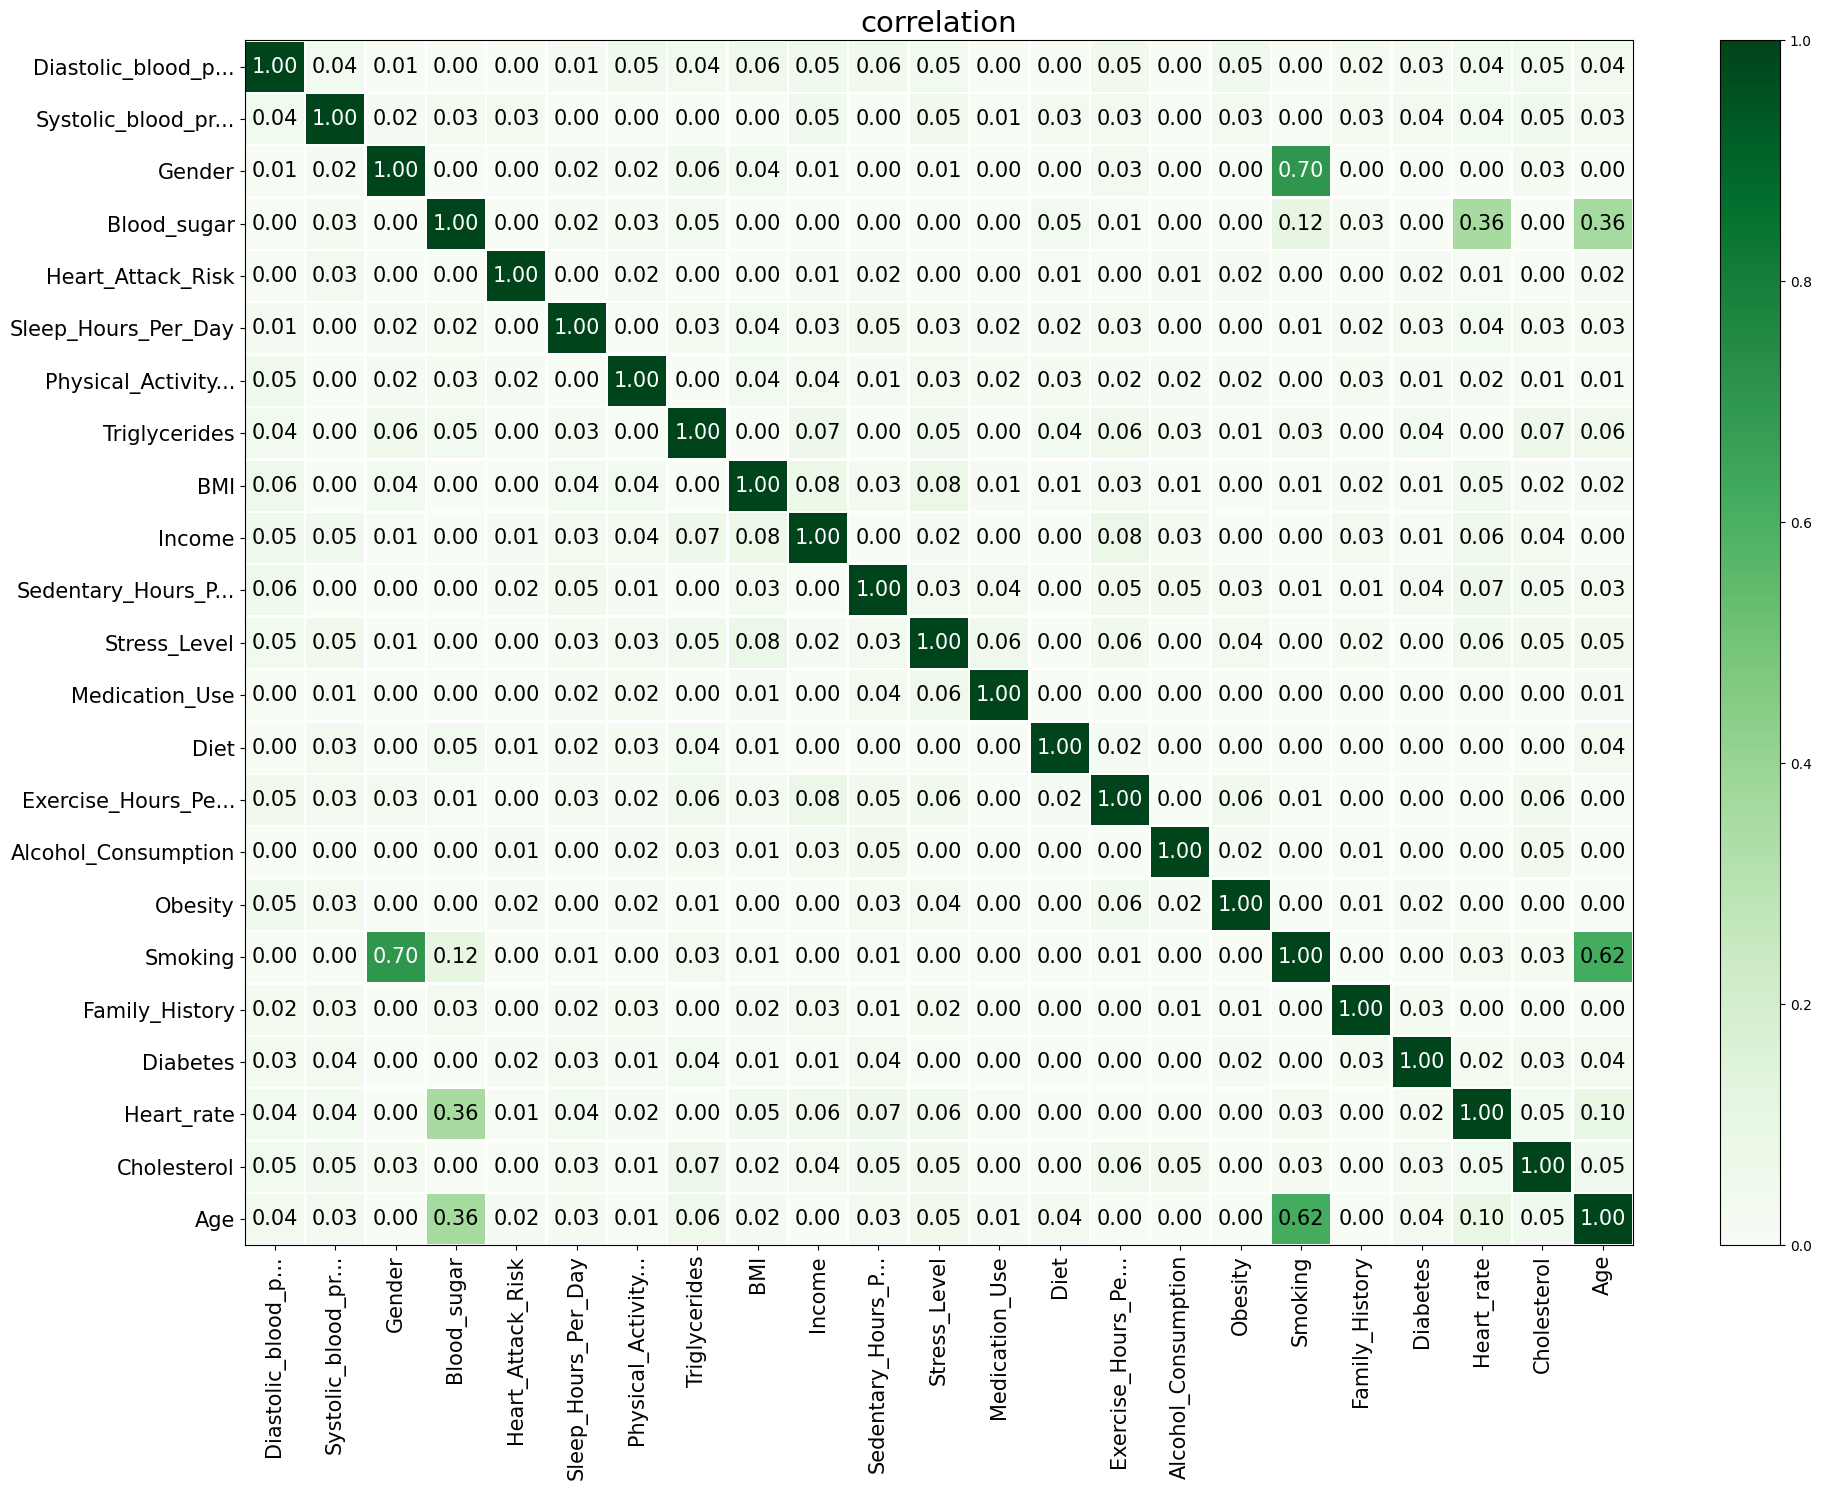

In [31]:
#построим тепловую карту корреляции признаков
matrix = phik_matrix(data.drop(['id', 'CK-MB', 'Troponin', 'Previous_Heart_Problems', 'Unnamed: 0'], axis=1));
plot_correlation_matrix(
    matrix.values,
    x_labels=matrix.columns,
    y_labels=matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

После анализа матрицы корреляции решено удалить сильно коррелирующие признаки 'Smoking' и 'Gender'. 

## Обучение модели RandomForestClassifier

In [32]:
#создадим датасет с необходимыми признаками
data_new_0 = data.drop(['Unnamed: 0', 'CK-MB', 'Troponin', 'Income','Smoking', 'Gender', 'Previous_Heart_Problems'], axis=1)

In [33]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [34]:
X = data_new_0.drop(['id','Heart_Attack_Risk'], axis=1)
y = data_new_0['Heart_Attack_Risk']

In [35]:
#применим ADASYN
# экземпляр сэмплера
sampler = ADASYN(random_state=RANDOM_STATE)

# сэмплируем данные
X_resample, y_resample = sampler.fit_resample(X, y)

C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resample,
    y_resample,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y_resample)

In [37]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200, min_samples_leaf = 1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [38]:
y_scores = model.predict_proba(X_test)[:, 1]  # предсказанные вероятности для класса 1

Для проверки качества модели были выбраны следующие метрики: roc-auc для оценки вероятностных предсказаний, F1-score для комплексной оценки модели, с учетом ложно-положительных и ложно-отрицательных случаев. Также использованы recall и precision для определения порога классификации.

In [39]:
# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC-AUC:", round(roc_auc, 2))

ROC-AUC: 0.81


In [40]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 1, 1])

In [41]:
fscore = f1_score(y_test, y_pred)
print("f-score:", round(fscore, 2))

f-score: 0.73


In [42]:
# проводим оценку точности
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

recall:  0.682
precision:  0.784


In [43]:
data = pd.DataFrame(zip(y_test, y_scores),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
data.head(20)

,y_valid,y_proba
177,1,0.990
2426,1,0.975
711,1,0.960
65,1,0.960
43,1,0.950
585,1,0.950
2340,1,0.945
801,1,0.945
138,1,0.945
1635,1,0.940


In [44]:
thresholds = [round(i,2) for i in np.linspace(0.6,1,num = 50,endpoint=False)]

In [45]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x:1  if x > i else 0)
    recall = recall_score(data['y_valid'], data['y_pred_'+str(i)], zero_division='warn')
    precision = precision_score(data['y_valid'], data['y_pred_'+str(i)], zero_division='warn')
    #if recall==1:
        #data_new = data['y_pred_'+str(i)]
        #break
    #print('recall ' + str(i) + ':',round(recall,5))
    print('precision ' + str(i) + ':',round(precision,5))

precision 0.6: 0.92347
precision 0.61: 0.92686
precision 0.62: 0.93352
precision 0.62: 0.93352
precision 0.63: 0.9384
precision 0.64: 0.94651
precision 0.65: 0.95179
precision 0.66: 0.96078
precision 0.66: 0.96078
precision 0.67: 0.96552
precision 0.68: 0.96937
precision 0.69: 0.97533
precision 0.7: 0.9741
precision 0.7: 0.9741
precision 0.71: 0.9789
precision 0.72: 0.98194
precision 0.73: 0.98765
precision 0.74: 0.9893
precision 0.74: 0.9893
precision 0.75: 0.99713
precision 0.76: 0.99691
precision 0.77: 0.99667
precision 0.78: 0.99638
precision 0.78: 0.99638
precision 0.79: 1.0
precision 0.8: 1.0
precision 0.81: 1.0
precision 0.82: 1.0
precision 0.82: 1.0
precision 0.83: 1.0
precision 0.84: 1.0
precision 0.85: 1.0
precision 0.86: 1.0
precision 0.86: 1.0
precision 0.87: 1.0
precision 0.88: 1.0
precision 0.89: 1.0
precision 0.9: 1.0
precision 0.9: 1.0
precision 0.91: 1.0
precision 0.92: 1.0
precision 0.93: 1.0
precision 0.94: 1.0
precision 0.94: 1.0
precision 0.95: 1.0
precision 0.96: 

C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ниже отражены полученные в  ходе моделирования метрики. Было найдено оптимальное значение для выбранных метрик. Также был расчитан порог классификации.

|ROC-AUC | F1-score | recall |precision|Порог классификации|
|--------------|---------------|---------------|---------------|---------------|
| 0.81        | 0.73          | 0.682           |0.784         |0.79

Метрики имеют достаточный уровень для предоставленных исходных данных. Для получения более высоких критериев стоит провести дополнительное обучение на новых данных.


<AxesSubplot:>

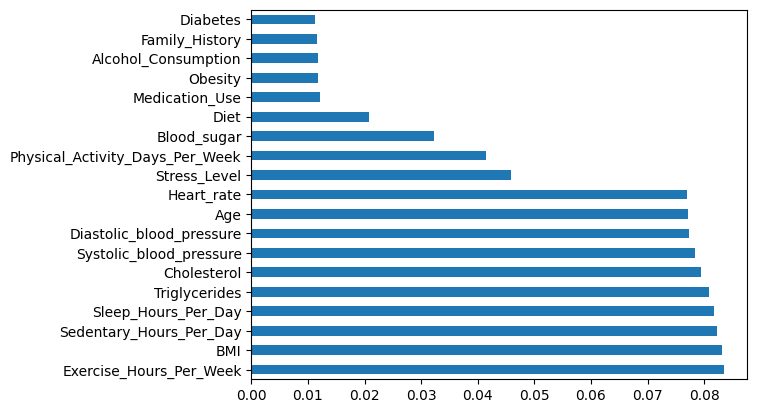

In [46]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='barh')

Для определения важности признаков использовали модель и feature_importances_. Но любые попытки удалить незначимые признаки снижали качество модели, поэтому было решено оставить набор признаков, который был выявлен в начале.

## Выгрузка модели для FastAPI

In [47]:
#joblib.dump(model, 'C:/Users/Даша/rfc.joblib')

Для работы приложения нам пригодится файл с обученной моделью.Строка закоментирована. Если нужно повторно выгрузить файл с моделью, нужно раскомментировать строку и запустить.

# Итоговые выводы

В рамках текущего проекта была разработана модель для предсказания риска сердечного приступа. Для обучения модели были предобработанны данные, проведен исследовательский и корреляционный анализ, применен метод ADASYN для устранения дисбаланса классов.

Для решения задачи классификации выбрана модель RandomForestClassifier, так как она хорошо справляется с числовыми данными.

Для проверки качества модели были выбраны следующие метрики: roc-auc для оценки вероятностных предсказаний, F1-score для комплексной оценки модели, с учетом ложно-положительных и ложно-отрицательных случаев. Также использованы recall и precision для определения порога классификации.

|ROC-AUC | F1-score | recall |precision|Порог классификации|
|--------------|---------------|---------------|---------------|---------------|
| 0.81        | 0.73          | 0.682           |0.784         |0.79

Метрики имеют достаточный уровень для предоставленных исходных данных. Порог классификации будет использован для предсказания рисков на реальных данных заказчика.